In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

from scipy.stats import spearmanr


In [2]:
target_dir = "./B/target/intermediates/"
shadow_dir = "./B/output/intermediates/"

#no_shadows = 64
#no_samples = 99

#random_target = False

scores = {}


In [3]:
from sampling import load_results

target_logits, target_inmask = load_results(target_dir+"/lira", signal_name="rescaled_logits.npy")
shadow_logits, shadow_inmask = load_results(shadow_dir+"/lira", signal_name="rescaled_logits.npy")
target_probs, _ = load_results(target_dir+"/rmia", signal_name="gtl_probabilities.npy")
assert (_==target_inmask).all()
shadow_probs, _ = load_results(shadow_dir+"/rmia", signal_name="gtl_probabilities.npy")
assert (_==shadow_inmask).all()
print(target_logits.shape, target_probs.shape, target_inmask.shape)
print(shadow_logits.shape, shadow_probs.shape, shadow_inmask.shape)


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 64 total
NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 64 total
(60000, 1) (60000, 1) (60000, 1)
(60000, 64) (60000, 64) (60000, 64)


In [4]:
%%time

from leakpro.attacks.mia_attacks.lira import lira_vectorized

scores["lira"] = lira_vectorized(target_logits.ravel(), shadow_logits, shadow_inmask, var_calculation = "individual_carlini")


CPU times: user 386 ms, sys: 12.1 ms, total: 399 ms
Wall time: 397 ms


In [5]:
%%time

from leakpro.attacks.mia_attacks.rmia import rmia_vectorised

scores["rmia"] = rmia_vectorised(target_probs.ravel(), shadow_probs, shadow_inmask, z_indices=np.arange(0,60000,5))


CPU times: user 103 ms, sys: 1.23 s, total: 1.33 s
Wall time: 1.42 s


In [6]:
from sklearn.metrics import roc_curve

curves = { 
    key: roc_curve(target_inmask[~np.isnan(scores[key]),0], scores[key][~np.isnan(scores[key])]) for key in scores.keys()
}


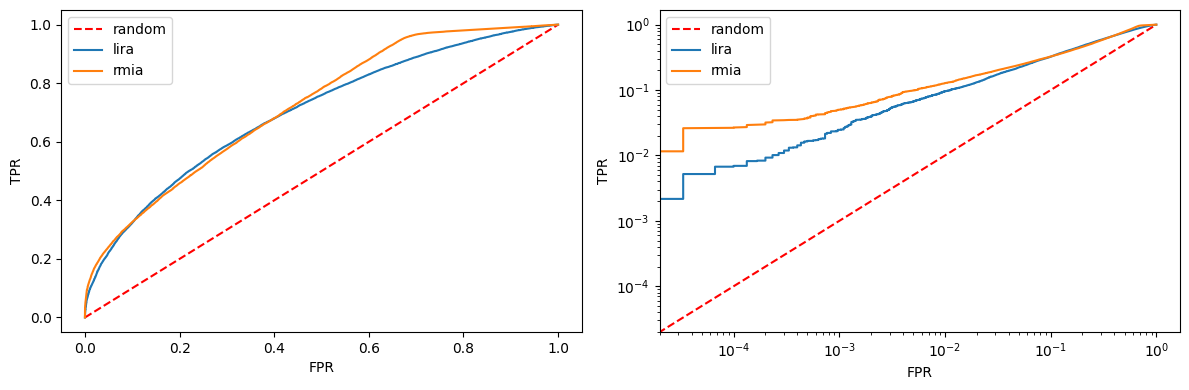

In [7]:
fpr0 = curves["lira"][0]

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr0, fpr0, 'r--', label="random")
axs[1].loglog(fpr0, fpr0, 'r--', label="random")
for i in [0,1]:
    for (key,(fpr, tpr, _)) in curves.items():
        axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


In [8]:
thresholds = { 
    key: l[np.where(fpr >= 0.01)[0][0]].item() for (key, (fpr, tpr, l)) in curves.items() 
}    
thresholds


{'lira': -0.00455437938344696, 'rmia': 0.9304166436195374}

In [9]:
tp = {
    key: (scores[key] > thresholds[key]) & target_inmask.ravel() for key in scores.keys()
}


In [10]:
print("TPR for each set", [tp[key].sum()/sum(target_inmask) for key in curves.keys()])
print("Intersection", np.sum(tp["lira"] & tp["rmia"])/sum(target_inmask))
print("Union", np.sum(tp["lira"] | tp["rmia"])/sum(target_inmask))


TPR for each set [array([0.096]), array([0.1271])]
Intersection [0.07106667]
Union [0.15203333]


In [11]:
rho, p_value = spearmanr(scores["lira"], scores["rmia"])

print(f"Spearman's rank correlation (rho): {rho}")
print(f"P-value: {p_value}")


Spearman's rank correlation (rho): 0.7236035038257946
P-value: 0.0


In [14]:
from scipy.stats import rankdata

scores_rank = {
    key: rankdata(score) for (key, score) in scores.items()
}

scores_rank


{'lira': array([57116., 11291., 26907., ...,  9371., 22033., 14980.],
       shape=(60000,)),
 'rmia': array([45658.5, 21096. , 36049.5, ..., 28155.5, 39032.5, 19471.5],
       shape=(60000,))}

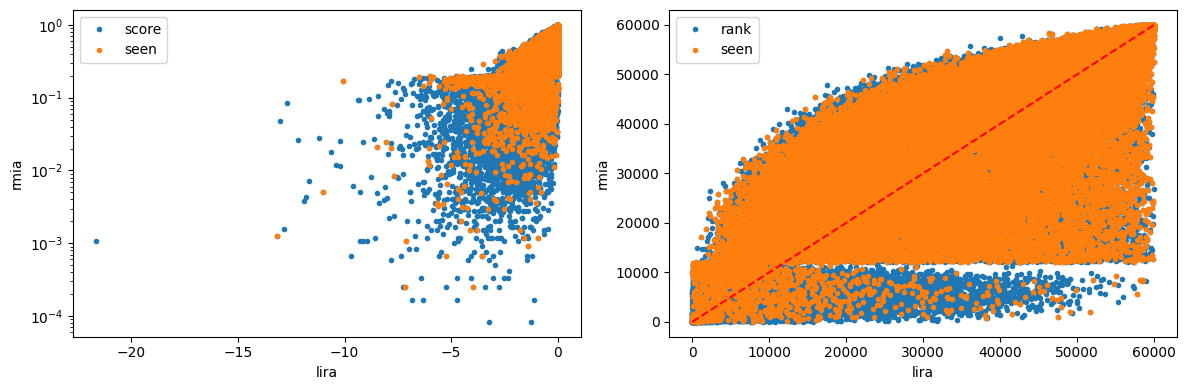

In [43]:

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].semilogy(scores["lira"], scores["rmia"], '.', label="score")
axs[1].plot(scores_rank["lira"], scores_rank["rmia"], '.', label="rank")
axs[0].semilogy(scores["lira"][target_inmask.ravel()], scores["rmia"][target_inmask.ravel()], '.', label="seen")
axs[1].plot(scores_rank["lira"][target_inmask.ravel()], scores_rank["rmia"][target_inmask.ravel()], '.', label="seen")
for i in [0,1]:
    axs[i].set_xlabel("lira")
    axs[i].set_ylabel("rmia")
    axs[i].legend()
xy = np.linspace(0,60000,10)
axs[1].plot(xy, xy, 'r--')
plt.tight_layout()
plt.show()


In [15]:
curves_rank = { 
    key: roc_curve(target_inmask[~np.isnan(scores_rank[key]),0], scores_rank[key][~np.isnan(scores_rank[key])]) for key in scores_rank.keys()
}
curves_rank["lira"]

(array([0.        , 0.        , 0.        , ..., 0.99993333, 0.99993333,
        1.        ], shape=(26023,)),
 array([0.00000000e+00, 3.33333333e-05, 2.16666667e-03, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00], shape=(26023,)),
 array([       inf, 6.0000e+04, 5.9936e+04, ..., 4.0000e+00, 3.0000e+00,
        1.0000e+00], shape=(26023,)))

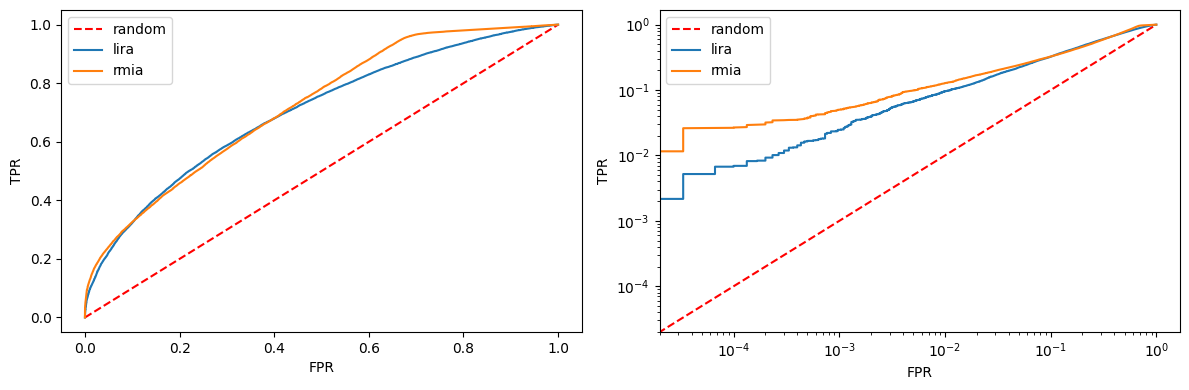

In [16]:
fpr00 = np.linspace(0,1,10)

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr00, fpr00, 'r--', label="random")
axs[1].loglog(fpr00, fpr00, 'r--', label="random")
for i in [0,1]:
    for (key,(fpr, tpr, _)) in curves_rank.items():
        axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


In [17]:
lira_scores = scores_rank["lira"]
rmia_scores = scores_rank["rmia"]


In [18]:

import numpy as np
import torch

def setup_gpu_tensors(
    lira_scores: np.ndarray,            # shape (n,)
    rmia_scores: np.ndarray,            # shape (n,)
    target_inmask: np.ndarray,          # shape (n,), dtype=bool
    lira_threshold: np.ndarray = None,  # optional candidate thresholds for lira, shape (K_l,)
    rmia_threshold: np.ndarray = None,  # optional candidate thresholds for rmia, shape (K_r,)
    device: str = 'cuda',
):
    """
    Move data to GPU and prepare masks and class counts.
    Returns a dict of tensors on the selected device.

    If lira_threshold / rmia_threshold are None, they default to the score tensors
    (you can then slice them to form chunks).
    """
    dev = torch.device(device if torch.cuda.is_available() else 'cpu')

    # Core data on device
    lira_scores_t = torch.as_tensor(lira_scores, device=dev, dtype=torch.float32)  # (n,)
    rmia_scores_t = torch.as_tensor(rmia_scores, device=dev, dtype=torch.float32)  # (n,)
    pos_mask_t    = torch.as_tensor(target_inmask.ravel(), device=dev, dtype=torch.bool)   # (n,)
    neg_mask_t    = ~pos_mask_t

    # Class counts
    n_pos_t = pos_mask_t.sum().clamp(min=1).to(torch.float32)
    n_neg_t = neg_mask_t.sum().clamp(min=1).to(torch.float32)

    # Candidate thresholds (default to scores if not provided)
    lira_threshold_t = lira_scores_t if lira_threshold is None \
        else torch.as_tensor(lira_threshold, device=dev, dtype=torch.float32)
    rmia_threshold_t = rmia_scores_t if rmia_threshold is None \
        else torch.as_tensor(rmia_threshold, device=dev, dtype=torch.float32)

    # Ensure 1-D shape for thresholds
    if lira_threshold_t.ndim != 1:
        lira_threshold_t = lira_threshold_t.flatten()
    if rmia_threshold_t.ndim != 1:
        rmia_threshold_t = rmia_threshold_t.flatten()

    return {
        'device': dev,
        'lira_scores': lira_scores_t,
        'rmia_scores': rmia_scores_t,
        'lira_threshold': lira_threshold_t,
        'rmia_threshold': rmia_threshold_t,
        'pos_mask': pos_mask_t,
        'neg_mask': neg_mask_t,
        'n_pos': n_pos_t,
        'n_neg': n_neg_t,
    }


In [19]:

import pandas as pd
import torch

def eval_chunk(state: dict, i: int, j: int, chunk: int) -> pd.DataFrame:
    """
    Evaluate TPR/FPR on a Cartesian grid of thresholds:
      l_thres = state['lira_threshold'][i*chunk : i*chunk + chunk]
      r_thres = state['rmia_threshold'][j*chunk : j*chunk + chunk]
    Returns a pandas DataFrame with columns: l, r, fpr, tpr. Length = chunk * chunk
    """
    # Slices for threshold vectors (shape: (chunk,))
    l0, l1 = i * chunk, i * chunk + chunk
    r0, r1 = j * chunk, j * chunk + chunk

    l_thres = state['lira_threshold'][l0:l1].to(torch.float32)
    r_thres = state['rmia_threshold'][r0:r1].to(torch.float32)

    # Basic sanity checks
    K_l = l_thres.numel()
    K_r = r_thres.numel()
    if K_l == 0 or K_r == 0:
        raise ValueError("Empty threshold slice: check i, j, chunk.")
    if K_l != chunk or K_r != chunk:
        # Not strictly required, but helps catch partial last chunks
        pass  # you may allow partial chunks; flattening still works

    # Scores and masks (already on device)
    l_score = state['lira_scores']
    r_score = state['rmia_scores']
    pos_mask = state['pos_mask'][:, None, None]
    neg_mask = state['neg_mask'][:, None, None]

    # Selection grid: (n, K_l, K_r)
    # Using >= as in your code; switch to > if that is the intended semantics
    sel = ((l_score[:, None, None] >= l_thres[None, :, None]) &
           (r_score[:, None, None] >= r_thres[None, None, :]))

    # Counts per grid point → (K_l, K_r)
    tp = (sel & pos_mask).sum(dim=0).to(torch.float32)
    fp = (sel & neg_mask).sum(dim=0).to(torch.float32)

    # Rates
    tpr = tp / state['n_pos']  # (K_l, K_r)
    fpr = fp / state['n_neg']  # (K_l, K_r)

    # Flatten in row-major order (r varies fastest)
    # Align thresholds with the same flattening order
    l_flat = l_thres.repeat_interleave(K_r)          # length K_l * K_r
    r_flat = r_thres.repeat(K_l)                     # length K_l * K_r
    fpr_flat = fpr.flatten()
    tpr_flat = tpr.flatten()

    # Build DataFrame on CPU
    df = pd.DataFrame({
        'l':   l_flat.detach().cpu().numpy(),
        'r':   r_flat.detach().cpu().numpy(),
        'fpr': fpr_flat.detach().cpu().numpy(),
        'tpr': tpr_flat.detach().cpu().numpy(),
    })
    return df


In [20]:
# ------------------------------------------------------------
# Pareto frontier (minimize FPR, maximize TPR), keep (l, r)
# ------------------------------------------------------------
def pareto_front(df: pd.DataFrame) -> pd.DataFrame:
    # Work on (fpr, tpr, l, r); drop duplicates in case any slipped in
    dd = df[["fpr", "tpr", "l", "r"]].dropna().drop_duplicates()
    # Sort by FPR asc, TPR desc; then keep TPR record-highs
    dd = dd.sort_values(["fpr", "tpr"], ascending=[True, False])
    best_tpr = -np.inf
    keep = []
    for row in dd.itertuples(index=False):
        fpr, tpr, l, r = row
        if tpr > best_tpr:
            keep.append(row)
            best_tpr = tpr
    frontier = pd.DataFrame(keep, columns=["fpr", "tpr", "l", "r"]).reset_index(drop=True)
    return frontier

In [25]:
import itertools

#from tqdm.notebook import tqdm
from tqdm.auto import tqdm

verbose = False
chunk = 64
keeps = 8192
front = None

results = {}
    
#for skip_size in [1024,256,64,16,4,1]:
for skip_size in [1024,512,256,128,64,32,16,8,4,2,1]:

    no_indices = 2**16//skip_size
 
    thresholds = np.arange(no_indices)*skip_size
    state = setup_gpu_tensors(lira_scores, rmia_scores, target_inmask, thresholds, thresholds)
    
    if front is None:
        indices = np.arange(no_indices//chunk) 
        uniq_pairs = list(itertools.product(indices, repeat=2))  # length = len(indices)**2
        if verbose: print("len(uniq_pairs)",len(uniq_pairs))    
    else:
        if False: # only keep pareto front points as candidates
            store = front
        else: # also keep near frontier points as candidates
            batch["eps"] = batch["fpr"].apply(lambda x: np.interp(x, front["fpr"], front["tpr"])) - batch["tpr"]         
            store = batch.sort_values("eps")#[:len(front)*10]
        l_vec = store["l"].to_numpy()  # float array
        r_vec = store["r"].to_numpy()  # float array        
        lq = np.floor(l_vec / skip_size/chunk).astype(np.int64)
        rq = np.floor(r_vec / skip_size/chunk).astype(np.int64)
        pairs = np.stack([lq, rq], axis=1)               # shape (N, 2)
        cutoff = len(pairs)
        uniq_pairs = []
        flag = True
        while flag or len(uniq_pairs) > keeps:
            if verbose: print("cutoff", cutoff)
            uniq_pairs = np.unique(pairs[:cutoff,:], axis=0)            # shape (K, 2
            if verbose: print("len(uniq_pairs)",len(uniq_pairs))    
            cutoff = cutoff // 2
            flag = False    
        if verbose: print("len(front)", len(front))
        if verbose: print("len(pairs)", len(pairs))
        
    
    for i, j in tqdm(uniq_pairs, desc=f"For skip_size={skip_size}", unit="chunk"):
        if verbose: print(f"Processing i={i}, j={j}")
        batch = eval_chunk(state, i, j, chunk)
        if verbose: print("- batch.shape",batch.shape)
        if front is not None:
            batch = pd.concat([front, batch], ignore_index=True)
        front = pareto_front(batch)
        if verbose: print("- front.shape",front.shape)
        
        
    results[skip_size] = uniq_pairs, front


For skip_size=1: 100%|██████████| 3504/3504 [03:53<00:00, 15.00chunk/s]


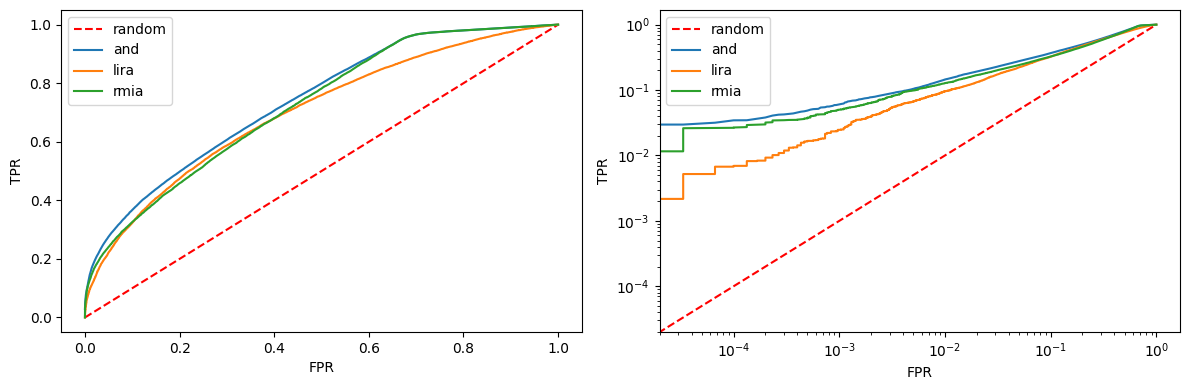

In [31]:
fpr00 = np.linspace(0,1,10)

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr00, fpr00, 'r--', label="random")
axs[1].loglog(fpr00, fpr00, 'r--', label="random")
for i in [0,1]:
    #axs[i].plot(df["fpr"],df["tpr"], '-.', label="or")
    #axs[i].plot(df["fpr"],df["tpr"], '-.', label="and")
    #axs[i].plot(store["fpr"],store["tpr"], '.')
    axs[i].plot(front["fpr"],front["tpr"], '-', label="and")    
    for (key,(fpr, tpr, _)) in curves_rank.items():
        axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.savefig("strong_comparison.png")
plt.savefig("strong_comparison.pdf")
plt.show()


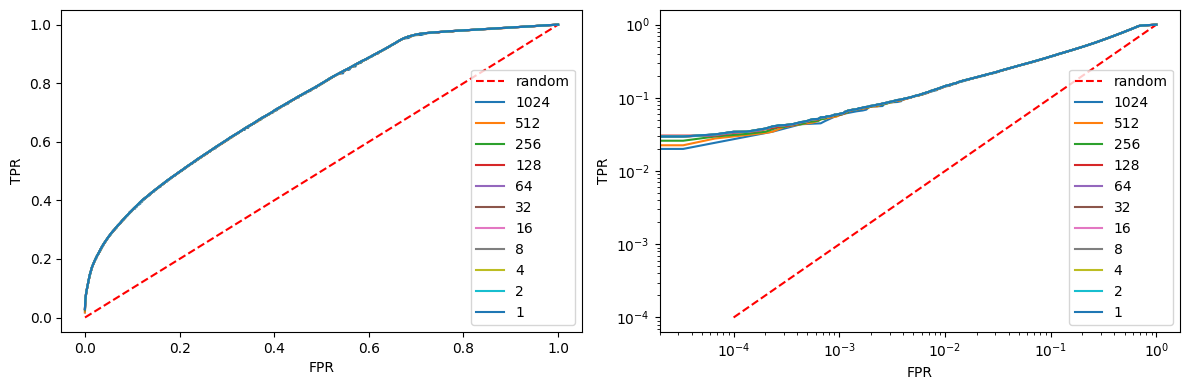

In [30]:
fpr00 = 10**(np.linspace(-4,0,100))
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr00, fpr00, 'r--', label="random")
axs[1].loglog(fpr00, fpr00, 'r--', label="random")
for i in [0,1]:
    for key in results.keys():
        front = results[key][1]
        axs[i].plot(front["fpr"],front["tpr"], '-', label=key)    
    #for (key,(fpr, tpr, _)) in curves_rank.items():
    #    axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.savefig("rank_optimization.png")
plt.savefig("rank_optimization.pdf")
plt.show()

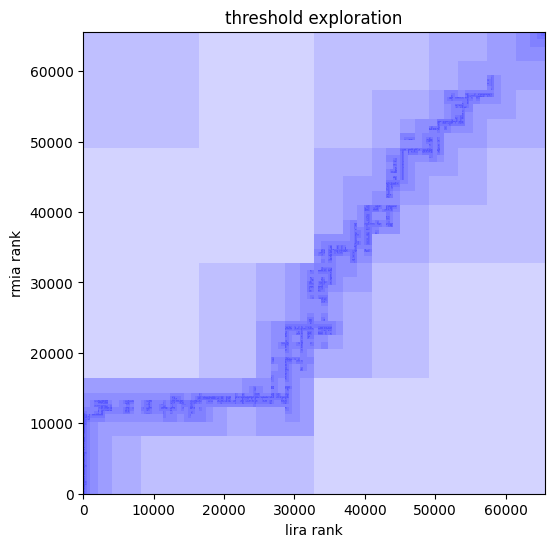

In [29]:

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(6, 6))

for key in results.keys():
    uniq_pairs = np.array(results[key][0])
    dist = key*chunk
    x = uniq_pairs[:,0]*dist
    y = uniq_pairs[:,1]*dist
    
    for xi, yi in zip(x, y):
        ax.add_patch(Rectangle((xi, yi), width=dist, height=dist,
                               facecolor='blue', edgecolor='none', linewidth=1.5, alpha=1.0/len(results)))

ax.set_aspect('equal', adjustable='box')  # squares stay square
ax.set_xlim(0 - dist*0.1, 65535 + dist*1.1)
ax.set_ylim(0 - dist*0.1, 65535 + dist*1.1)
ax.set_xlabel('lira rank')
ax.set_ylabel('rmia rank')
ax.set_title('threshold exploration')
plt.savefig("rank_exploration.png")
plt.savefig("rank_exploration.pdf")
plt.show()


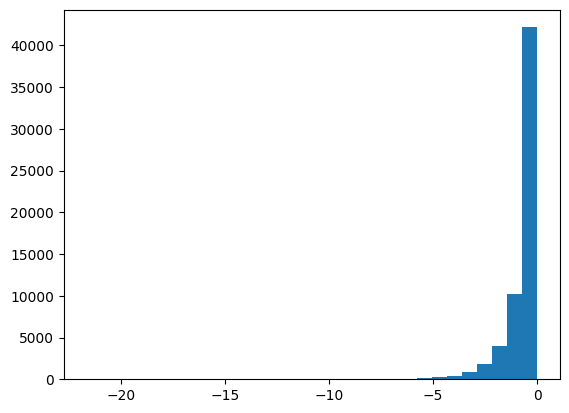

In [32]:
plt.hist(scores["lira"], bins=30)
plt.show()


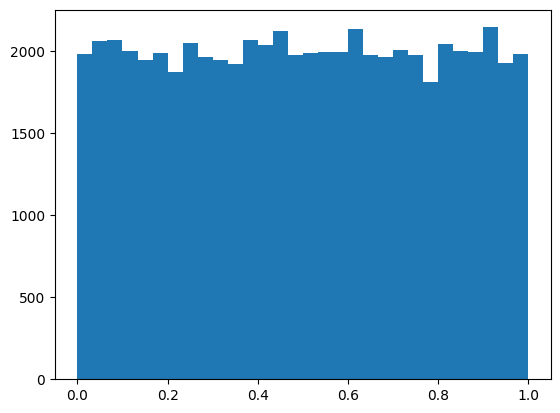

In [33]:
plt.hist(scores["rmia"], bins=30)
plt.show()

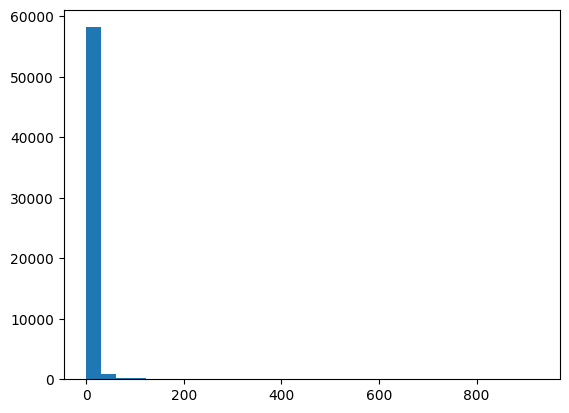

In [34]:
eps = 1e-3
plt.hist((lambda s: (eps+s)/((1-s)+eps))(scores["rmia"]), bins=30)
plt.show()


In [35]:
%%time

from leakpro.attacks.mia_attacks.base import base_practical

base_score = base_practical(np.log(target_probs.ravel()), np.log(shadow_probs), shadow_inmask)


CPU times: user 75.8 ms, sys: 52.1 ms, total: 128 ms
Wall time: 127 ms


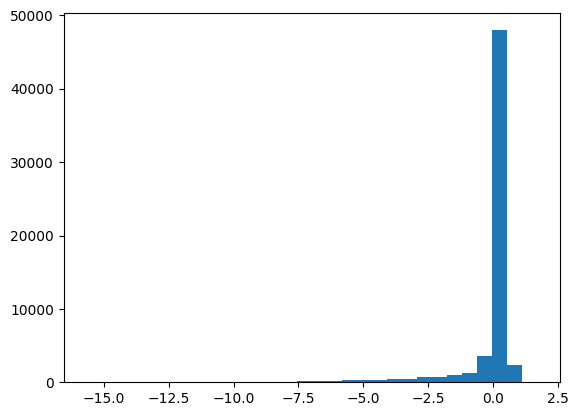

In [36]:
plt.hist(base_score, bins=30)
plt.show()